# 列舉所有資產的riskiness r

In [1]:
import sympy
from pandas import Series,DataFrame
from scipy.optimize import fsolve
import math
import time
import pandas as pd
import numpy  as  np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 無風險利率
* 我們須扣除無風險利率，得到超額報酬率以計算Riskiness r
* 目前使用LIBOR [1個月利率](https://www.global-rates.com/interest-rates/libor/american-dollar/usd-libor-interest-rate-overnight.aspx)

In [2]:
rfrate = 2.45785 / 12 /100
rfrate

0.0020482083333333333

# 自定義 functions，用來計算風險指標
- get_riskiness_r(guess , arr_returns)
    - 計算Riskiness R
- get_all_risk_with_return_data(df)
    - 傳入多組ETF的月報酬序列資料，分別計算各組ETF的Riskiness R
- get_top5(df)
    - 依照R值排序，並傳回前5名的ETF
    
### 關於超額報酬的數量級:
* 將要帶入公式的數值調整到介在0-100間，目的是為了讓大部分的Riskiness r介在0-100間。

In [3]:
def f1(x,arr_returns):
    return sum( np.exp(-1*arr_returns/x) ) - len(arr_returns)

def get_riskiness_r(guess,arr_returns):
    while (guess<1000):
        risk2 = fsolve(f1,guess,arr_returns)  #引用函數f1
        if risk2[0] != guess:
            break
        guess = guess*10
    return risk2[0]

def get_all_risk_with_return_data(df):
    global rfrate
    
    etf_list = list(df.columns)
    etf_risk = []
    
    # 計算每支ETF的riskiness r
    for etf_name in etf_list:
        etf_returns = df[etf_name] - rfrate  
        guess = 10**(-5)
        risk_r = get_riskiness_r(guess,etf_returns)
        etf_risk.append([etf_name,risk_r])
        
    df = pd.DataFrame(etf_risk,columns=['Name','Riskiness R'])
    return df

def get_top5(df):
    df_sorted = df.sort_values(by=['Riskiness R'])
    df_top5 = df_sorted[:5]
    return df_top5

# 自定義 functions，用來計算最佳配置的權重值


In [4]:
def risk(x):
    guess  = 10**(-5)
    while (guess<1000):
        risk2 = fsolve(f1,guess,x)  #引用函數f1
        if risk2[0] != guess:
            break
        guess = guess*10
    return risk2[0]
    #return np.std(x)

def sumrisk(weight,all_return):
    w = weight
    a = all_return
    v = 0
    for i in range(len(w)):
        v = v + w[i]*risk(w[i]*(all_return.iloc[:,i]))
    return v

def penalty(w):
    if min(w)<0 or max(w)>1:
        return 100000
    else:
        return 0

def portretmean(weight,all_return):
    w = weight
    a = all_return
    return np.mean(np.dot(np.array(all_return),np.array(weight)))    

def bestweight(w,all_return):
    r = []
    r.append(penalty(w)+np.abs(sum(w)-1))
    for i in range(len(w)-1):
        v =  np.abs( risk(w[i]*(all_return.iloc[:,i]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i])-rfrate)/(portretmean(w,all_return)-rfrate) ) \
            + np.abs( risk(w[i+1]*(all_return.iloc[:,i+1]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i+1])-rfrate)/(portretmean(w,all_return)-rfrate))
        r.append(v) 
    print('權重:',w,'誤差值:',v+penalty(w)+np.abs(sum(w)-1))
    return r

def fourdrop(x):
    a = []
    for i in range(len(x)):
        a.append(round(sum(x[i]),3))
    return a

# 完整的處理流程

依序產生以下檔案

- 每月資料夾下有4個檔案
    - all_group_return.csv：用來存所有群組的月報酬(該月報酬即為該群前5名ETF的月報酬之平均值)
    - all_group_risk.csv：用來存每個群組的Riskiness R(該Riskiness R是以該群月報酬去計算)
    - top5_group_list.csv：用來存所有群組中Riskiness R最小的前5名
    - top5_group_weight.csv：用來存前5名群組的最佳配置權重
    
- 每群資料夾下也有4個檔案
    - all_etf_return.csv：用來存該群中所有ETF的月報酬資料
    - all_etf_risk.csv：用來存該群中每支ETF以月報酬計算出來的Riskiness R
    - top5_etf_list.csv：用來存該群中前5名的ETF(以 Riskiness R 排序)
    - top5_etf_return.csv：用來存該群中前5名的ETF的月報酬取之平均值

In [21]:
def get_total_months(data_path):
    subdir = os.listdir(data_path)[0] #取第一個group的csv檔
    file_path = data_path + subdir + '/' + subdir + '_return.csv'
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        total_rows = df.shape[0]
        return total_rows

In [22]:
return_data_path = '../2014to2018RE_data/'
risk_data_path = '../2017to2019Risk_data/'

# 以程式取得資料總筆數
total_data = get_total_months(return_data_path)
print('共有',total_data,'個月的資料')

# 指定用來計算指標的資料個數
window_size = 36
print('取',window_size,'個月的資料計算風險指標')

rolling_times = total_data - window_size
print('共滾動',rolling_times,'次')

共有 61 個月的資料
取 36 個月的資料計算風險指標
共滾動 25 次


In [7]:
for i in range(rolling_times):
    print('=== Rolling #',i+1,'===')
    
    #第一層目錄
    first_month = '2017-01-01'
    first_date = datetime.strptime(first_month,'%Y-%m-%d')
    the_date = first_date + relativedelta(months=i)
    date_string = the_date.strftime('%Y-%m-%d')
    risk_dir_path = os.path.join(risk_data_path,date_string)
    if not os.path.exists(risk_dir_path):
        os.makedirs(risk_dir_path)
        print('新增資料夾',risk_dir_path)
        
    #第二層目錄
    risk_dir_path_2nd = os.path.join(risk_dir_path,'all_groups/')
    if not os.path.exists(risk_dir_path_2nd):
        os.makedirs(risk_dir_path_2nd)
        print('新增資料夾',risk_dir_path_2nd)

    allgroup_top5_return = DataFrame()
    allgroup_top5_dict = dict()
    
    for subdir in os.listdir(return_data_path):
        #第三層目錄(group name)
        risk_dir_path_3rd = os.path.join(risk_dir_path_2nd,subdir)
        if not os.path.exists(risk_dir_path_3rd):
            os.makedirs(risk_dir_path_3rd)
            print('新增資料夾',risk_dir_path_3rd)
        
        subdir_path = os.path.join(return_data_path,subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            file = subdir + '_return.csv'
            file_path = os.path.join(subdir_path, file)
            if os.path.isfile(file_path):
                df = pd.read_csv(file_path)
                df_return = df.iloc[i:i+window_size,2:]
                print(df_return.shape)
                df_return = df_return.dropna(axis=1)
                print(df_return.shape)
                
                #第三層目錄下的檔案
                # 0. all_etf_return.csv
                csv_file = "all_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_return.to_csv(save_path,index=False)
                
                # 1. all_etf_risk.csv
                df_etf_risk = get_all_risk_with_return_data(df_return)
                csv_file = "all_etf_risk.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_etf_risk.to_csv(save_path,index=False)
                
                # 2. top5_etf_list.csv
                df_top5_etf = get_top5(df_etf_risk)
                csv_file = "top5_etf_list.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_top5_etf.to_csv(save_path,index=False)
                
                # 3. top5_etf_return.csv
                top5_etf = df_top5_etf['Name']
                top5_return_average = df_return[top5_etf].mean(axis=1)
                allgroup_top5_return[subdir] = top5_return_average
                
                csv_file = "top5_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                top5_return_average.to_csv(save_path,index=False)
                
                # 4. the_group_risk.csv
                # 改在第二層
                
                #[ top5_etf,allgroup_top5_return[subdir] ] = get_top5_etf(df)
                print('Group:',subdir)
                print('Top5:',top5_etf)
                print('================')
                #allgroup_top5_dict[subdir] = top5_etf
                
    #第二層
    # 4. all_group_return
    csv_file = "all_group_return.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    allgroup_top5_return.to_csv(save_path,index=False)
    
    # 5. all_group_risk
    df_group_risk = get_all_risk_with_return_data(allgroup_top5_return)
    csv_file = "all_group_risk.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_group_risk.to_csv(save_path,index=False)
    
    # 6. top5_group_list
    df_top5_group = get_top5(df_group_risk)
    csv_file = "top5_group_list.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_top5_group.to_csv(save_path,index=False)
    
    # 7. top_group_weight
    top5_group = df_top5_group['Name']    
    top5_group_return = allgroup_top5_return[top5_group]
    n = top5_group_return.shape[1]
    weight = [1/n]*n
    top5_group_best_weight = fsolve(bestweight,weight,top5_group_return)
    print(top5_group_best_weight)
    
    weight_list = []
    for i,group_name in enumerate(top5_group):
        group_weight = top5_group_best_weight[i]
        weight_list.append([group_name,group_weight])
    
    df_best_weight = pd.DataFrame(weight_list,columns=['Name','Weight'])
    print(df_best_weight)
    
    csv_file = "top5_group_weight.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_best_weight.to_csv(save_path,index=False)


=== Rolling # 1 ===
新增資料夾 ../2017to2019Risk_data/2017-01-01
新增資料夾 ../2017to2019Risk_data/2017-01-01/all_groups/
新增資料夾 ../2017to2019Risk_data/2017-01-01/all_groups/Alternatives ETF List (35)
(36, 21)
(36, 14)


/Users/alexis/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/alexis/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-01-01/all_groups/Healthcare Equity ETF List (49)
(36, 34)
(36, 25)
Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
8     IHF
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-01-01/all_groups/Developed Markets ETF List 1 (100)
(36, 80)
(36, 66)
Group: Developed Markets ETF List 1 (100)
Top5: 26    IDOG
62     VSS
63      VT
59    URTH
39     KXI
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-01-01/all_groups/Target Maturity Date Corporate Bond ETF List (24)
(36, 16)
(36, 6)
Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
0    BSCJ
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-01-01/all_groups/Global ETF List (72)
(36, 40)
(36, 31)
Group: Global ETF List (72)
Top5: 0     AADR
15    GDXJ
13    FONE
19     IFV

權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043742051271325
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.004374196727471
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043741705078775
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.004374184524064
權重: [ 22.55694245   0.32513842  24.65295858 -28.30046166 -17.62199571] 誤差值: 100001.97896580203
權重: [ 0.10498541  0.39999792 -6.98635033 -1.40481584  6.19420281] 誤差值: 100004.90598738665
權重: [ 0.52635872  0.39999775 -3.40374356  0.70377581  0.1339991 ] 誤差值: 100004.14178326054
權重: [0.22283099 0.40000194 0.97283226 0.24700374 0.31465185] 誤差值: 2.6558672526983607
權重: [-0.0610177   0.45558722  0.79336532  0.62703177  0.61387107] 誤差值: 100002.16740869291
權重: [0.26940127 0.59812823 1.71908814 0.25809327 0.43469264] 誤差值: 100003.20494615352
權重: [0.222831   0.40000194 0.97283226 0.24700374 0.31465185] 誤差值: 2.6558672422011713
權重: [0.22283099 0.40000194 0.97283226 0.24700374 0.31465185] 誤差值: 2.655867250263359
權重: [0.22283099 0.40000194 0.97283227 0.24700374 0.31465185] 誤差值: 2.6558672598313695
權重: [0.222830

Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
11    PSCD
15     RXI
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-02-01/all_groups/Total Bond Market ETF List (82)
(36, 36)
(36, 23)
Group: Total Bond Market ETF List (82)
Top5: 10    HOLD
16    NEAR
21    ULST
15    MINT
22    XMPT
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-02-01/all_groups/Developed Markets ETF List 3 (93)
(36, 28)
(36, 15)
Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
7     FTAG
11     IPO
6      FLM
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-02-01/all_groups/Treasuries ETF List (51)
(36, 41)
(36, 38)
Group: Treasuries ETF List (51)
Top5: 27     TUZ
17     SHY
36    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-02-01/all_groups/Gold ETF List (17)
(36, 12)
(36, 11)
Group: Gold ETF List (17)
Top5: 1     DGLD
10    UGLD
3      DGZ
7      IAU
9      UBG
Name: Name, dtyp

/Users/alexis/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-03-01/all_groups/Healthcare Equity ETF List (49)
(36, 34)
(36, 25)
Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
8     IHF
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-03-01/all_groups/Developed Markets ETF List 1 (100)
(36, 80)
(36, 67)
Group: Developed Markets ETF List 1 (100)
Top5: 27    IDOG
63     VSS
64      VT
25    HEFA
60    URTH
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-03-01/all_groups/Target Maturity Date Corporate Bond ETF List (24)
(36, 16)
(36, 6)
Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-03-01/all_groups/Global ETF List (72)
(36, 40)
(36, 32)
Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
16    GDXJ
20     IFV

權重: [0.29101382 0.35272644 0.34000459 0.24882292 0.10454154] 誤差值: 2.0333885231546196
權重: [0.24344159 0.4803421  0.48318112 0.27727882 0.43180459] 誤差值: 2.420559765031195
權重: [0.24344159 0.4803421  0.48318112 0.27727882 0.43180459] 誤差值: 2.4205597749644623
權重: [0.24344159 0.4803421  0.48318112 0.27727882 0.43180459] 誤差值: 2.420559775627273
權重: [0.24344159 0.4803421  0.48318112 0.27727882 0.43180459] 誤差值: 2.4205597555401708
權重: [0.24344159 0.4803421  0.48318112 0.27727882 0.43180459] 誤差值: 2.4205597762688074
權重: [0.30312046 0.4985798  0.46809959 0.38080789 0.37718924] 誤差值: 1.9991863971068398
權重: [0.4027064  0.37982352 0.29587071 0.56734642 0.22968016] 誤差值: 1.5912281334339524
權重: [0.33544181 0.29624417 0.65154064 0.35053437 0.40425379] 誤差值: 1.9189002315429473
權重: [0.30312046 0.4985798  0.46809959 0.38080789 0.37718924] 誤差值: 1.9991863961553293
權重: [0.30312046 0.49857981 0.46809959 0.38080789 0.37718924] 誤差值: 1.999186408462521
權重: [0.30312046 0.4985798  0.4680996  0.38080789 0.37718924] 誤差值: 1.

Group: Industrials Equity ETF List (37)
Top5: 22    _PRN
6      FXR
7      IEV
1      CGW
19     VIS
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-04-01/all_groups/Financials Equity ETF List (51)
(36, 42)
(36, 36)
Group: Financials Equity ETF List (51)
Top5: 21     KIE
34     VQT
18    KBWP
32     UYG
6     FINZ
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-04-01/all_groups/Broad Asia ETF List (44)
(36, 27)
(36, 18)
Group: Broad Asia ETF List (44)
Top5: 17    VXUS
3      AIA
10     FPA
7     DBAP
9     EEMA
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-04-01/all_groups/Preferred Stock ETF List (12)
(36, 7)
(36, 7)
Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-04-01/all_groups/Emerging Asia Pacific ETF List (114)
(36, 78)
(36, 63)
Group: Emerging Asia Pacific ETF List (114)
Top5: 61    YINN
41    INDL
34     FXP
53    SMIN
39    INCO
Name: 

權重: [0.2606159  0.44232435 0.62065343 0.22506603 0.46449848] 誤差值: 1.3427730581591848
權重: [0.2606159  0.44232434 0.62065344 0.22506603 0.46449848] 誤差值: 1.3427730663262476
權重: [0.2606159  0.44232434 0.62065343 0.22506603 0.46449848] 誤差值: 1.342773047081657
權重: [0.2606159  0.44232434 0.62065343 0.22506603 0.46449849] 誤差值: 1.3427721646438036
權重: [0.25823619 0.44619081 0.61405996 0.2268997  0.46439014] 誤差值: 1.342416493551199
權重: [0.25334225 0.45304406 0.60021442 0.23061728 0.46418803] 誤差值: 1.3634162672999346
權重: [0.24316173 0.46487656 0.57126286 0.23905589 0.46406753] 誤差值: 1.4165026378912267
權重: [0.24880689 0.46031813 0.589337   0.23619    0.46425213] 誤差值: 1.4016970068750674
權重: [0.25334225 0.45304406 0.60021442 0.23061728 0.46418803] 誤差值: 1.3634162576333568
權重: [0.25334225 0.45304406 0.60021442 0.23061728 0.46418803] 誤差值: 1.3634162916655872
權重: [0.25334225 0.45304406 0.60021442 0.23061728 0.46418803] 誤差值: 1.363416280641907
權重: [0.25334225 0.45304406 0.60021442 0.23061729 0.46418803] 誤差值: 1.

Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
6      DOO
41     VPL
16     EWJ
22     FDT
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-05-01/all_groups/Materials Equity ETF List (62)
(36, 52)
(36, 46)
Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
2     CROP
10    GDXJ
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-05-01/all_groups/Real Estate ETF List (48)
(36, 35)
(36, 30)
Group: Real Estate ETF List (48)
Top5: 7      ICF
19     RWR
28     WPS
4      FRI
21    SCHH
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-05-01/all_groups/Utilities Equity ETF List (24)
(36, 17)
(36, 14)
Group: Utilities Equity ETF List (24)
Top5: 3     GII
12    VPU
13    XLU
5     IGF
11    UPW
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-05-01/all_groups/Consumer Discretionary Equity ETF List (31)
(36, 22)
(36, 20)
Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
11    PSCD
15     RXI
3    

權重: [0.29920172 0.47421752 0.44055836 0.42361495 0.25276499] 誤差值: 1.6497867411943543
[0.29920172 0.47421752 0.44055836 0.42361495 0.25276499]
                                          Name    Weight
0                    Real Estate ETF List (48)  0.299202
1           Developed Markets ETF List 1 (100)  0.474218
2        Developed Asia Pacific ETF List (108)  0.440558
3  Consumer Discretionary Equity ETF List (31)  0.423615
4             Industrials Equity ETF List (37)  0.252765
=== Rolling # 6 ===
新增資料夾 ../2017to2019Risk_data/2017-06-01
新增資料夾 ../2017to2019Risk_data/2017-06-01/all_groups/
新增資料夾 ../2017to2019Risk_data/2017-06-01/all_groups/Alternatives ETF List (35)
(36, 21)
(36, 14)
Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-06-01/all_groups/Healthcare Equity ETF List (49)
(36, 34)
(36, 25)
Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
8

權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.122357593571989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.122357593571989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.122357593571989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.122357583050607
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223575947099267
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223576008916876
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223575620687214
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223575728473616
權重: [ 0.62455394  0.28473969 -0.38785904 -0.16892751  0.64749292] 誤差值: 100009.01625721727
權重: [0.31913366 0.61588743 0.97034854 0.2961852  0.32328346] 誤差值: 2.568071486331145
權重: [0.34871292 0.45618563 0.86184619 0.33736512 0.36165445] 誤差值: 2.3401649396223294
權重: [ 0.50834086 -0.53150607  0.04637586  0.61581531  0.64430007] 誤差值: 100000.78302683758
權重: [0.33753764 0.246423   1.1537891  0.45002777 0.35945203] 誤差值: 100002.4880598987
權重: [0.34871293 0.45618563 0.86184619 0.33736512 0.36165445] 誤差值: 2.340164937129276
權重: [0.34871292 0.45618564 0.86184619 0.33736512 0.36165445] 誤差值: 2.340164946670954
權重:

Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
30    SOCL
16    GDXJ
20     IFV
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-07-01/all_groups/Municipal Bond ETF List (29)
(36, 14)
(36, 12)
Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
4      PZA
11     TFI
3      PVI
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-07-01/all_groups/Junk ETF List (43)
(36, 20)
(36, 18)
Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-07-01/all_groups/Commodity ETF List (125)
(36, 78)
(36, 76)
Group: Commodity ETF List (125)
Top5: 64     UCO
5     BOIL
28     DTO
55     SCO
44      LD
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-07-01/all_groups/Volatility ETF List (18)
(36, 8)
(36, 8)
Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-07-01/all_group

權重: [0.28321138 0.44489726 0.62107476 0.31262099 0.46121681] 誤差值: 1.5594311496856395
權重: [0.28321138 0.44489727 0.62107476 0.31262099 0.46121681] 誤差值: 1.55943115125954
權重: [0.28321138 0.44489726 0.62107476 0.31262099 0.46121681] 誤差值: 1.559431154509934
權重: [0.28321138 0.44489726 0.62107476 0.312621   0.46121681] 誤差值: 1.5594311367302898
權重: [0.28321138 0.44489726 0.62107476 0.31262099 0.46121682] 誤差值: 1.559430149718942
權重: [0.27509537 0.42683251 0.58958028 0.31550172 0.46150727] 誤差值: 1.4763022754491997
權重: [0.29054966 0.45126584 0.61665969 0.3163287  0.46104973] 誤差值: 1.5820007721814833
權重: [0.2796541  0.44253509 0.6256081  0.31036438 0.46129085] 誤差值: 1.5531267676068155
權重: [0.2782015  0.44173653 0.62961835 0.30909946 0.46127201] 誤差值: 1.5604359245295158
權重: [0.2803804  0.44293437 0.62360297 0.31099685 0.46130027] 誤差值: 1.5494953879534608
權重: [0.28182748 0.44370598 0.6194963  0.31225999 0.46131305] 誤差值: 1.5430561793062936
權重: [0.28468835 0.44514773 0.61095137 0.31477459 0.46131849] 誤差值: 1.5

Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-08-01/all_groups/Emerging Asia Pacific ETF List (114)
(36, 78)
(36, 67)
Group: Emerging Asia Pacific ETF List (114)
Top5: 65    YINN
45    INDL
38     FXP
43    INCO
12    CNXT
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-08-01/all_groups/Energy Equity ETF List (80)
(36, 60)
(36, 52)
Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
19    GRID
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-08-01/all_groups/Emerging Markets ETF List (79)
(36, 44)
(36, 37)
Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
3      BKF
7      DGS
36    TLTE
4     DBEM
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-08-01/all_groups/Telecom Equity ETF List (10)
(36, 8)
(36, 8)
Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, 

權重: [0.37300324 0.36320589 0.65209898 0.28123783 0.45337136] 誤差值: 1.7697894957945692
權重: [0.37466854 0.35320821 0.64618572 0.28363669 0.4520789 ] 誤差值: 1.7584307112329631
權重: [0.37804095 0.33337844 0.63431407 0.28852363 0.44955206] 誤差值: 1.734743778254758
權重: [0.38489068 0.29434378 0.61038674 0.29862019 0.44471057] 誤差值: 1.6854375517381226
權重: [0.39860463 0.21852787 0.56176085 0.3199207  0.43587927] 誤差值: 1.5781792653664997
權重: [0.42363474 0.07469999 0.46119638 0.36610985 0.42203695] 誤差值: 1.5537391007044135
權重: [ 0.52285098 -0.01448951  0.18732697  0.32101365  0.53452746] 誤差值: 100002.04057685741
權重: [0.53711957 0.19599381 0.45218866 0.39431562 0.39079445] 誤差值: 1.7342354143194851
權重: [0.42363475 0.07469999 0.46119638 0.36610985 0.42203695] 誤差值: 1.553739234172906
權重: [0.42363474 0.07469999 0.46119638 0.36610985 0.42203695] 誤差值: 1.553739102599018
權重: [0.42363474 0.07469999 0.46119639 0.36610985 0.42203695] 誤差值: 1.5537391188383456
權重: [0.42363474 0.07469999 0.46119638 0.36610985 0.42203695] 誤差

Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-09-01/all_groups/Total Bond Market ETF List (82)
(36, 36)
(36, 26)
Group: Total Bond Market ETF List (82)
Top5: 11    HOLD
18    NEAR
23    ULST
17    MINT
25    XMPT
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-09-01/all_groups/Developed Markets ETF List 3 (93)
(36, 28)
(36, 15)
Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
5     FDTS
11     IPO
3      EFO
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-09-01/all_groups/Treasuries ETF List (51)
(36, 41)
(36, 39)
Group: Treasuries ETF List (51)
Top5: 28     TUZ
17     SHY
37    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-09-01/all_groups/Gold ETF List (17)
(36, 12)
(36, 12)
Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
2      DGP
5      GLD
8     OUNZ
Name: Name, dtyp

Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 3    BSCO
6    IBDC
4    IBCD
5    IBCE
2    BSCN
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-10-01/all_groups/Global ETF List (72)
(36, 40)
(36, 34)
Group: Global ETF List (72)
Top5: 0     AADR
31    SOCL
14    FONE
16    GDXJ
25     LIT
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-10-01/all_groups/Municipal Bond ETF List (29)
(36, 14)
(36, 12)
Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-10-01/all_groups/Junk ETF List (43)
(36, 20)
(36, 19)
Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-10-01/all_groups/Commodity ETF List (125)
(36, 78)
(36, 76)
Group: Commodity ETF List (125)
Top5: 64     UCO
5     BOIL
28     DTO
55     SCO
44      LD
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_da

權重: [0.14628207 0.45779771 0.43155951 0.40486655 0.16624347] 誤差值: 1.711478766785412
權重: [0.22168069 0.42979292 0.36228928 0.31086825 0.41526594] 誤差值: 1.5054514208165592
權重: [0.21435896 0.4367892  0.42304364 0.38860562 0.31064496] 誤差值: 1.3434752280795212
權重: [0.21435896 0.43678921 0.42304364 0.38860562 0.31064496] 誤差值: 1.3434752653578168
權重: [0.21435896 0.4367892  0.42304365 0.38860562 0.31064496] 誤差值: 1.3434757853056691
權重: [0.21435896 0.4367892  0.42304364 0.38860562 0.31064496] 誤差值: 1.3434752352255739
權重: [0.21435896 0.4367892  0.42304364 0.38860562 0.31064497] 誤差值: 1.3434752343181606
權重: [0.2494868  0.4351492  0.42586333 0.37178714 0.30757894] 誤差值: 1.510791508061776
權重: [0.32958709 0.43045945 0.4254511  0.29633748 0.23117446] 誤差值: 1.1556829304826066
權重: [0.41701601 0.41882898 0.42888722 0.09788107 0.08632277] 誤差值: 1.6927041102491938
權重: [0.21053014 0.43233763 0.42429854 0.30474092 0.2546218 ] 誤差值: 1.2046315830629961
權重: [0.3295871  0.43045945 0.4254511  0.29633748 0.23117446] 誤差值: 1

Group: Commodity ETF List (125)
Top5: 64     UCO
5     BOIL
28     DTO
55     SCO
44      LD
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-11-01/all_groups/Volatility ETF List (18)
(36, 8)
(36, 8)
Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-11-01/all_groups/Currency ETF List (36)
(36, 25)
(36, 25)
Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
15     FXS
18     UDN
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-11-01/all_groups/Developed Markets ETF List 2 (100)
(36, 58)
(36, 41)
Group: Developed Markets ETF List 2 (100)
Top5: 18    FYLD
12     EFZ
38    TOLZ
9      DOO
25    IPKW
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-11-01/all_groups/Industrials Equity ETF List (37)
(36, 26)
(36, 23)
Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
新增資料

權重: [0.24851379 0.40011857 0.31227194 0.31527017 0.4390097 ] 誤差值: 1.4381974082530462
權重: [0.28424892 0.60245647 0.31267058 0.35125276 0.44627159] 誤差值: 2.104813095242542
權重: [0.29067534 0.56471982 0.32196361 0.45798834 0.44902164] 誤差值: 1.6850744340050403
權重: [0.29067534 0.56471983 0.32196361 0.45798834 0.44902164] 誤差值: 1.6850744479758104
權重: [0.29067534 0.56471982 0.32196361 0.45798834 0.44902164] 誤差值: 1.685074436081626
權重: [0.29067534 0.56471982 0.32196361 0.45798834 0.44902164] 誤差值: 1.6850742566167685
權重: [0.29067534 0.56471982 0.32196361 0.45798834 0.44902164] 誤差值: 1.685074444087694
權重: [0.25050137 0.50918348 0.31012162 0.45934694 0.44908952] 誤差值: 1.5954756239078955
權重: [0.17767506 0.39335091 0.2886913  0.4615877  0.44924508] 誤差值: 0.8911253708183524
權重: [0.21651905 0.45477607 0.29775656 0.46031858 0.4507537 ] 誤差值: 1.5011887161791333
權重: [0.15219005 0.33647632 0.27807235 0.46347422 0.45113088] 誤差值: 0.9131920503941306
權重: [0.19877964 0.40591913 0.29340639 0.46136333 0.45406748] 誤差值: 0.

Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-12-01/all_groups/Commodity ETF List (125)
(36, 78)
(36, 77)
Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
28     DTO
56     SCO
44      LD
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-12-01/all_groups/Volatility ETF List (18)
(36, 8)
(36, 8)
Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-12-01/all_groups/Currency ETF List (36)
(36, 25)
(36, 25)
Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
15     FXS
18     UDN
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2017-12-01/all_groups/Developed Markets ETF List 2 (100)
(36, 58)
(36, 42)
Group: Developed Markets ETF List 2 (100)
Top5: 18    FYLD
12     EFZ
39    TOLZ
9      DOO
25    IPKW
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/20

權重: [0.16833455 0.29666989 0.31877425 0.57100928 0.45153136] 誤差值: 1.3604831693500317
權重: [0.10069514 0.25922992 0.29889871 0.50764683 0.4784056 ] 誤差值: 1.279586612612606
權重: [0.18262574 0.30976367 0.32560518 0.58411556 0.40838044] 誤差值: 1.3012022176600098
權重: [0.16833456 0.29666989 0.31877425 0.57100928 0.45153136] 誤差值: 1.3604831702628453
權重: [0.16833455 0.29666989 0.31877425 0.57100928 0.45153136] 誤差值: 1.360483167606644
權重: [0.16833455 0.29666989 0.31877425 0.57100928 0.45153136] 誤差值: 1.3604831697548883
權重: [0.16833455 0.29666989 0.31877425 0.57100929 0.45153136] 誤差值: 1.3604831807995943
權重: [0.16833455 0.29666989 0.31877425 0.57100928 0.45153137] 誤差值: 1.360483180284516
權重: [0.14837377 0.28157395 0.32765213 0.56317003 0.44997724] 誤差值: 1.3457102730824966
權重: [0.11352255 0.25191255 0.34832353 0.54687723 0.44255577] 誤差值: 1.3018059535902269
權重: [0.10281801 0.22436064 0.42668817 0.54029665 0.4324989 ] 誤差值: 1.2779537893948028
權重: [0.11887481 0.2656885  0.30914121 0.55016752 0.4475842 ] 誤差值: 1.

權重: [0.1086683  0.12495092 0.27731114 0.46380372 0.4604709 ] 誤差值: 0.6847499290420606
權重: [0.10858583 0.10784599 0.2897219  0.46446289 0.45998385] 誤差值: 0.7356174967944514
權重: [0.1118196  0.1311144  0.2697166  0.46330311 0.46066276] 誤差值: 0.6844017559938445
權重: [0.10341184 0.1319338  0.26419732 0.46390483 0.46101576] 誤差值: 0.7232918726611988
權重: [0.10641334 0.131394   0.27319595 0.4631349  0.46056991] 誤差值: 0.75814124111873
權重: [0.1118196  0.1311144  0.2697166  0.46330311 0.46066276] 誤差值: 0.6844017568999694
權重: [0.1118196  0.1311144  0.2697166  0.46330311 0.46066276] 誤差值: 0.6844017566125626
權重: [0.1118196  0.1311144  0.2697166  0.46330311 0.46066276] 誤差值: 0.6844017552785984
權重: [0.1118196  0.1311144  0.2697166  0.46330312 0.46066276] 誤差值: 0.6844016782763906
權重: [0.1118196  0.1311144  0.2697166  0.46330311 0.46066276] 誤差值: 0.6844013550431225
權重: [0.11038035 0.1289001  0.26861938 0.46347076 0.46069771] 誤差值: 0.6792086883042514
權重: [0.10841169 0.12388121 0.26641573 0.46376001 0.46074543] 誤差值: 0

Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
20    JNUG
32    RING
2     CROP
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-01-01/all_groups/Real Estate ETF List (48)
(36, 35)
(36, 31)
Group: Real Estate ETF List (48)
Top5: 21     RWX
6      GRI
4      FRI
30    WREI
20     RWR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-01-01/all_groups/Utilities Equity ETF List (24)
(36, 17)
(36, 15)
Group: Utilities Equity ETF List (24)
Top5: 3      GII
12     VPU
5      IGF
13    WBIC
11     UPW
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-01-01/all_groups/Consumer Discretionary Equity ETF List (31)
(36, 22)
(36, 21)
Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-01-01/all_groups/Total Bond Market ETF List (82)
(36, 36)
(36, 31)
Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
27    ULST
23   

權重: [0.15734045 0.14348099 0.21589573 0.46382384 0.19763858] 誤差值: 0.330069832512941
權重: [0.16103629 0.13548939 0.22010311 0.46396472 0.20221639] 誤差值: 0.31308787118422177
權重: [0.16103628 0.13548939 0.22010311 0.46396472 0.20221639] 誤差值: 0.31308787255195336
權重: [0.16103628 0.13548939 0.22010312 0.46396472 0.20221639] 誤差值: 0.3130878705049599
權重: [0.16103628 0.13548939 0.22010311 0.46396473 0.20221639] 誤差值: 0.313087795123844
權重: [0.16103628 0.13548939 0.22010311 0.46396472 0.20221639] 誤差值: 0.313087887727687
權重: [0.15777864 0.1376797  0.22214391 0.46411776 0.19947546] 誤差值: 0.3054938198299508
權重: [0.15364059 0.13971636 0.22689826 0.46450228 0.19260949] 誤差值: 0.3161792771559392
權重: [0.15984766 0.13666137 0.21976673 0.46392549 0.20290844] 誤差值: 0.3179187247880207
權重: [0.15777864 0.1376797  0.22214391 0.46411776 0.19947546] 誤差值: 0.30549382293257976
權重: [0.15777864 0.1376797  0.22214391 0.46411776 0.19947546] 誤差值: 0.30549382219588306
權重: [0.15777864 0.1376797  0.22214391 0.46411776 0.19947546] 誤差值

Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
22     VEU
3      AIA
7      CWI
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-02-01/all_groups/Preferred Stock ETF List (12)
(36, 7)
(36, 7)
Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-02-01/all_groups/Emerging Asia Pacific ETF List (114)
(36, 78)
(36, 69)
Group: Emerging Asia Pacific ETF List (114)
Top5: 7     CHAU
67    YINN
47    INDL
2      AIA
40     FXP
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-02-01/all_groups/Energy Equity ETF List (80)
(36, 60)
(36, 54)
Group: Energy Equity ETF List (80)
Top5: 17    GASL
20    GRID
43     PZD
12     FCG
11     FAN
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-02-01/all_groups/Emerging Markets ETF List (79)
(36, 44)
(36, 40)
Group: Emerging Markets ETF List (79)
Top5: 4     DBEM
7      DGS
38    TLTE
30    IEMG
22    EMQQ
Name: Name

權重: [0.41924215 0.33866505 0.37980191 0.46681567 0.33190765] 誤差值: 1.1044211721319512
權重: [0.41924215 0.33866505 0.37980191 0.46681568 0.33190765] 誤差值: 1.1044211243441553
權重: [0.41924215 0.33866505 0.37980191 0.46681567 0.33190765] 誤差值: 1.1044211814109903
權重: [0.4187511  0.33496192 0.38007776 0.46836423 0.33011495] 誤差值: 1.0767783515691394
權重: [0.4178055  0.32698367 0.38048555 0.47132537 0.32621914] 誤差值: 1.0638616092934465
權重: [0.4173331  0.3272775  0.37830536 0.47041101 0.33028111] 誤差值: 1.0749937465457329
權重: [0.41780551 0.32698367 0.38048555 0.47132537 0.32621914] 誤差值: 1.063861478878335
權重: [0.4178055  0.32698368 0.38048555 0.47132537 0.32621914] 誤差值: 1.0638616156276202
權重: [0.4178055  0.32698367 0.38048556 0.47132537 0.32621914] 誤差值: 1.0638616156195009
權重: [0.4178055  0.32698367 0.38048555 0.47132538 0.32621914] 誤差值: 1.0638615621628886
權重: [0.4178055  0.32698367 0.38048555 0.47132537 0.32621914] 誤差值: 1.0638616055506351
權重: [0.41804297 0.32446584 0.38066036 0.47141569 0.32574643] 誤差值: 

Group: Utilities Equity ETF List (24)
Top5: 4      GII
13     VPU
14    WBIC
12     UPW
9     PSCU
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-03-01/all_groups/Consumer Discretionary Equity ETF List (31)
(36, 22)
(36, 21)
Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-03-01/all_groups/Total Bond Market ETF List (82)
(36, 36)
(36, 32)
Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
28    ULST
23    RAVI
22    NEAR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-03-01/all_groups/Developed Markets ETF List 3 (93)
(36, 28)
(36, 17)
Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
10    GDXS
1     CROP
5     FDTS
7     FPXI
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-03-01/all_groups/Treasuries ETF List (51)
(36, 41)
(36, 40)
Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
1

權重: [-1.45186013e-04  8.57857440e-02  3.04511035e-01  4.26301266e-01
  3.24284141e-01] 誤差值: 100002.07723994124
權重: [0.06986036 0.08075697 0.30852179 0.42606962 0.31916922] 誤差值: 0.531638965613401
權重: [0.06986036 0.08075697 0.30852179 0.42606962 0.31916922] 誤差值: 0.531638966287593
權重: [0.06986036 0.08075697 0.30852179 0.42606962 0.31916922] 誤差值: 0.5316389660820614
權重: [0.06986036 0.08075697 0.3085218  0.42606962 0.31916922] 誤差值: 0.5316389792041551
權重: [0.06986036 0.08075697 0.30852179 0.42606963 0.31916922] 誤差值: 0.5316391959343537
權重: [0.06986036 0.08075697 0.30852179 0.42606962 0.31916923] 誤差值: 0.5316389548055592
權重: [0.06791134 0.08069146 0.30802011 0.42578454 0.31950874] 誤差值: 0.5531377248540296
權重: [0.06646014 0.08066475 0.30749932 0.42550013 0.31988792] 誤差值: 0.5891906114109275
權重: [0.06863694 0.08070481 0.3082805  0.42592675 0.31931915] 誤差值: 0.5355471008798762
權重: [0.06794718 0.0767991  0.30898356 0.42604272 0.31921979] 誤差值: 0.5291308589461681
權重: [0.06875673 0.08270096 0.30793952 0.4

Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
28    ULST
23    RAVI
22    NEAR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-04-01/all_groups/Developed Markets ETF List 3 (93)
(36, 28)
(36, 18)
Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
16    ROGS
10    GDXS
1     CROP
5     FDTS
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-04-01/all_groups/Treasuries ETF List (51)
(36, 41)
(36, 40)
Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-04-01/all_groups/Gold ETF List (17)
(36, 12)
(36, 12)
Group: Gold ETF List (17)
Top5: 1     DGLD
10     UBG
7      IAU
9     SGOL
5      GLD
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-04-01/all_groups/Crude Oil ETF List (22)
(36, 9)
(36, 9)
Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2

Group: Junk ETF List (43)
Top5: 6    HYLD
8    HYND
4    HYHG
5    HYIH
2    GHYG
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-05-01/all_groups/Commodity ETF List (125)
(36, 78)
(36, 77)
Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
27    DSLV
56     SCO
44      LD
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-05-01/all_groups/Volatility ETF List (18)
(36, 8)
(36, 8)
Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-05-01/all_groups/Currency ETF List (36)
(36, 25)
(36, 25)
Group: Currency ETF List (36)
Top5: 21    USDU
9      FXA
15     FXS
4      CYB
11     FXC
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-05-01/all_groups/Developed Markets ETF List 2 (100)
(36, 58)
(36, 47)
Group: Developed Markets ETF List 2 (100)
Top5: 19    FYLD
13     EFZ
32    IVAL
10     DOO
28    IPKW
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/20

權重: [0.16405512 0.44492825 0.34043536 0.35173071 0.2270726 ] 誤差值: 1.9223820999483812
權重: [0.19145041 0.3710022  0.34591121 0.43470492 0.20798257] 誤差值: 1.9421240715559558
權重: [0.15509985 0.41245579 0.34823574 0.41711943 0.20474492] 誤差值: 1.9954197424744735
權重: [0.15509985 0.4124558  0.34823574 0.41711943 0.20474492] 誤差值: 1.9954198282194997
權重: [0.15509985 0.41245579 0.34823575 0.41711943 0.20474492] 誤差值: 1.9954197339523474
權重: [0.15509985 0.41245579 0.34823574 0.41711943 0.20474492] 誤差值: 1.9954197381596188
權重: [0.15509985 0.41245579 0.34823574 0.41711943 0.20474492] 誤差值: 1.9954197322394611
權重: [0.10961543 0.41013975 0.35253476 0.42359159 0.20977873] 誤差值: 1.5106425309656304
權重: [0.04788735 0.40973843 0.33693933 0.45595639 0.21242185] 誤差值: 1.5867807169856443
權重: [0.1202744  0.409736   0.3627452  0.40854144 0.21031071] 誤差值: 1.8730018740134595
權重: [0.10961544 0.41013975 0.35253476 0.42359159 0.20977873] 誤差值: 1.5106425323694728
權重: [0.10961543 0.41013975 0.35253476 0.42359159 0.20977873] 誤差值:

Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
3     IXP
1    FCOM
6     VOX
7     XTL
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-06-01/all_groups/Technology Equity ETF List (75)
(36, 47)
(36, 43)
Group: Technology Equity ETF List (75)
Top5: 9      IGM
33    TDIV
13     IXN
26    SCID
5     FTEC
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-06-01/all_groups/Consumer Staples Equity ETF List (26)
(36, 16)
(36, 16)
Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
4      IYK
6      PBJ
13    WBID
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-06-01/all_groups/Developed Asia Pacific ETF List (108)
(36, 61)
(36, 50)
Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
36    IVAL
6      DOO
49     VPL
16     EWJ
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-06-01/all_groups/Materials Equity ETF List (62)
(36, 52)
(36, 51)
Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
23    JNUG


Group: Alternatives ETF List (35)
Top5: 15     QLS
5     FLAG
11     MOM
18     SIZ
8     HTUS
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-07-01/all_groups/Healthcare Equity ETF List (49)
(36, 34)
(36, 32)
Group: Healthcare Equity ETF List (49)
Top5: 16    LABU
10     IBB
31    ZBIO
30     XPH
24    UBIO
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-07-01/all_groups/Developed Markets ETF List 1 (100)
(36, 80)
(36, 77)
Group: Developed Markets ETF List 1 (100)
Top5: 29    IDOG
72     VSS
47     KXI
73      VT
26    HEFA
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-07-01/all_groups/Target Maturity Date Corporate Bond ETF List (24)
(36, 16)
(36, 15)
Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDP
14    IBDQ
3     BSCO
12    IBDO
6     IBDC
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-07-01/all_groups/Global ETF List (72)
(36, 40)
(36, 36)
Group: Global ETF List (72)
Top5: 18    GDXS
33    SOCL
0     AADR

權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160553491877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160551664498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160739119017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160371881856
權重: [-2.47013162  1.13954522  0.86751973  1.13984061  0.32322606] 誤差值: 100000.68468736607
權重: [-1.3090775   0.08053014  0.16304824  0.0832177   0.45192057] 誤差值: 100004.81631980212
權重: [0.14416454 0.35008212 0.35349389 0.35132917 0.19658507] 誤差值: 1.5952756786729414
權重: [0.07487743 0.50659323 0.48927603 0.50833642 0.1923818 ] 誤差值: 3.636463595383951
權重: [-0.09262583  0.2835589   0.31548054  0.28446314  0.15500461] 誤差值: 100002.63804620873
權重: [0.14416454 0.35008212 0.35349389 0.35132917 0.19658507] 誤差值: 1.5952756805162227
權重: [0.14416454 0.35008212 0.35349389 0.35132917 0.19658507] 誤差值: 1.5952756759028377
權重: [0.14416454 0.35008212 0.35349389 0.35132917 0.19658507] 誤差值: 1.5952756755502926
權重: [0.14416454 0.35008212 0.35349389 0.35132918 0.19658507] 誤差值: 1.59527568834896
權重: [0.14416454 0.35008

Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-08-01/all_groups/Total Bond Market ETF List (82)
(36, 36)
(36, 33)
Group: Total Bond Market ETF List (82)
Top5: 15    HOLD
22    MINT
29    ULST
24    RAVI
23    NEAR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-08-01/all_groups/Developed Markets ETF List 3 (93)
(36, 28)
(36, 22)
Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
12    HSCZ
18    SCID
17    ROGS
10    GDXS
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-08-01/all_groups/Treasuries ETF List (51)
(36, 41)
(36, 40)
Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-08-01/all_groups/Gold ETF List (17)
(36, 12)
(36, 12)
Group: Gold ETF List (17)
Top5: 1    DGLD
7     IAU
9    SGOL
5     GLD
8    OUNZ
Name: Name, dtype: ob

Group: Developed Markets ETF List 1 (100)
Top5: 74     VSS
49     KXI
66    SDIV
22     GII
48     JXI
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-09-01/all_groups/Target Maturity Date Corporate Bond ETF List (24)
(36, 16)
(36, 15)
Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDP
14    IBDQ
3     BSCO
12    IBDO
6     IBDC
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-09-01/all_groups/Global ETF List (72)
(36, 40)
(36, 38)
Group: Global ETF List (72)
Top5: 26    IQDF
37    VIDI
2     CRAK
6      EEM
24    IEMG
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-09-01/all_groups/Municipal Bond ETF List (29)
(36, 14)
(36, 14)
Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-09-01/all_groups/Junk ETF List (43)
(36, 20)
(36, 20)
Group: Junk ETF List (43)
Top5: 6    HYLD
8    HYND
4    HYHG
5    HYIH
2    GHYG
Name: Name, dtype

權重: [0.34261887 0.31896772 0.30218336 0.30761081 0.21869428] 誤差值: 1.8998180557052644
權重: [0.57583012 0.4784045  0.43584104 0.44884813 0.25253379] 誤差值: 2.745659625815116
權重: [0.35302409 0.42131534 0.37956055 0.34876782 0.21944678] 誤差值: 2.2462705920587656
權重: [0.34261888 0.31896772 0.30218336 0.30761081 0.21869428] 誤差值: 1.8998180603632318
權重: [0.34261887 0.31896772 0.30218336 0.30761081 0.21869428] 誤差值: 1.899818050445743
權重: [0.34261887 0.31896772 0.30218337 0.30761081 0.21869428] 誤差值: 1.8998180534134452
權重: [0.34261887 0.31896772 0.30218336 0.30761082 0.21869428] 誤差值: 1.89981806605833
權重: [0.34261887 0.31896772 0.30218336 0.30761081 0.21869429] 誤差值: 1.8998180474851987
權重: [0.09553749 0.34116974 0.35005561 0.31729706 0.25245674] 誤差值: 1.5809358937359708
權重: [-0.33932143  0.38851948  0.44905031  0.34313147  0.32111666] 誤差值: 100002.09135409899
權重: [0.38799178 0.37184189 0.3752757  0.34280246 0.24121588] 誤差值: 1.9071448548586756
權重: [0.09553749 0.34116974 0.35005561 0.31729706 0.25245674] 誤差值

Group: Utilities Equity ETF List (24)
Top5: 4     GII
8     JXI
2     FXU
14    VPU
5     IDU
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-10-01/all_groups/Consumer Discretionary Equity ETF List (31)
(36, 22)
(36, 21)
Group: Consumer Discretionary Equity ETF List (31)
Top5: 19    WBIA
18     VCR
7      PBS
3     FDIS
15     RXI
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-10-01/all_groups/Total Bond Market ETF List (82)
(36, 36)
(36, 34)
Group: Total Bond Market ETF List (82)
Top5: 22    MINT
15    HOLD
30    ULST
25    RAVI
23    NEAR
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-10-01/all_groups/Developed Markets ETF List 3 (93)
(36, 28)
(36, 23)
Group: Developed Markets ETF List 3 (93)
Top5: 11     HGI
6      FLM
12    HSCZ
16    PAGG
19    SCID
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-10-01/all_groups/Treasuries ETF List (51)
(36, 41)
(36, 40)
Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    

Group: Junk ETF List (43)
Top5: 6     HYLD
8     HYND
2     GHYG
0     ANGL
11     JNK
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-11-01/all_groups/Commodity ETF List (125)
(36, 78)
(36, 78)
Group: Commodity ETF List (125)
Top5: 12     DBA
31    FTGC
34     GCC
72    USCI
5     BOIL
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-11-01/all_groups/Volatility ETF List (18)
(36, 8)
(36, 8)
Group: Volatility ETF List (18)
Top5: 2    UVXY
5    VIXY
7     ZIV
0    SVXY
1    TVIX
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-11-01/all_groups/Currency ETF List (36)
(36, 25)
(36, 25)
Group: Currency ETF List (36)
Top5: 21    USDU
12    FXCH
15     FXS
9      FXA
1      CEW
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-11-01/all_groups/Developed Markets ETF List 2 (100)
(36, 58)
(36, 56)
Group: Developed Markets ETF List 2 (100)
Top5: 36    IQDY
17     EFZ
23    FYLD
4      CID
18    EUMV
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_da

權重: [0.29152431 0.21239159 0.10620162 0.18190316 0.26462784] 誤差值: 0.32091037247630627
權重: [0.33580997 0.23360886 0.10294825 0.1862969  0.2671661 ] 誤差值: 0.332363967787487
權重: [0.32104809 0.22653643 0.1040327  0.18483232 0.26632001] 誤差值: 0.33233176027509925
權重: [0.32104809 0.22653644 0.1040327  0.18483232 0.26632001] 誤差值: 0.33233175857559294
權重: [0.32104809 0.22653643 0.10403271 0.18483232 0.26632001] 誤差值: 0.3323317578093372
權重: [0.32104809 0.22653643 0.1040327  0.18483232 0.26632001] 誤差值: 0.33233177616658494
權重: [0.32104809 0.22653643 0.1040327  0.18483232 0.26632002] 誤差值: 0.3323317371713699
權重: [0.31274003 0.22443307 0.10202238 0.18339092 0.26837516] 誤差值: 0.2823013677295756
權重: [0.31909739 0.22756206 0.10588818 0.18555844 0.26661834] 誤差值: 0.33596904372674596
權重: [0.32404072 0.2268204  0.10403127 0.18501966 0.26563716] 誤差值: 0.33922087754379415
權重: [0.31955177 0.22639445 0.10403342 0.18473865 0.26666144] 誤差值: 0.328890779261374
權重: [0.316569   0.22610678 0.10403901 0.18455154 0.26734584] 

Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-12-01/all_groups/Emerging Asia Pacific ETF List (114)
(36, 78)
(36, 75)
Group: Emerging Asia Pacific ETF List (114)
Top5: 67     VWO
1     ADRE
10    CHAU
73    YINN
69    XINA
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-12-01/all_groups/Energy Equity ETF List (80)
(36, 60)
(36, 59)
Group: Energy Equity ETF List (80)
Top5: 23    GUSH
19    GASL
8     DRIP
5     CRAK
47     PZD
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-12-01/all_groups/Emerging Markets ETF List (79)
(36, 44)
(36, 44)
Group: Emerging Markets ETF List (79)
Top5: 2     BICK
13     EEB
8     DVYE
0     ADRE
40    TLEH
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2018-12-01/all_groups/Telecom Equity ETF List (10)
(36, 8)
(36, 8)
Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
7     XTL
2    FONE
Name: Name, 

權重: [0.4144944  0.17410017 0.17250149 0.23201371 0.18221935] 誤差值: 0.35264929039609205
權重: [0.4144944  0.17410017 0.17250149 0.2320137  0.18221936] 誤差值: 0.352649328320807
權重: [0.40676666 0.17176916 0.17152872 0.2345981  0.18109602] 誤差值: 0.32277779447839294
權重: [0.39078352 0.16674011 0.1702306  0.23957218 0.17930383] 誤差值: 0.26714409618663515
權重: [0.41475824 0.17428368 0.17217778 0.23211107 0.18199212] 誤差值: 0.35065241150038307
權重: [0.40676667 0.17176916 0.17152872 0.2345981  0.18109602] 誤差值: 0.3227777984362954
權重: [0.40676666 0.17176916 0.17152872 0.2345981  0.18109602] 誤差值: 0.32277779638873105
權重: [0.40676666 0.17176916 0.17152873 0.2345981  0.18109602] 誤差值: 0.32277779649373484
權重: [0.40676666 0.17176916 0.17152872 0.23459811 0.18109602] 誤差值: 0.3227777743567004
權重: [0.40676666 0.17176916 0.17152872 0.2345981  0.18109603] 誤差值: 0.32277781236024805
權重: [0.41017201 0.17320784 0.17097192 0.23554669 0.18049812] 誤差值: 0.316274463954501
權重: [0.41695164 0.17617263 0.16995598 0.23736168 0.17936699]

Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
8      PSL
7     PSCC
12     VDC
1     EMCG
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2019-01-01/all_groups/Developed Asia Pacific ETF List (108)
(36, 61)
(36, 60)
Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
49    JPMV
8      DTH
41    IDOG
7      DOO
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2019-01-01/all_groups/Materials Equity ETF List (62)
(36, 52)
(36, 52)
Group: Materials Equity ETF List (62)
Top5: 16    GUNR
15    GRES
22    JDST
4     DUST
11    GDXS
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2019-01-01/all_groups/Real Estate ETF List (48)
(36, 35)
(36, 35)
Group: Real Estate ETF List (48)
Top5: 24     RWX
10    IFGL
3      FFR
33     WPS
20     REM
Name: Name, dtype: object
新增資料夾 ../2017to2019Risk_data/2019-01-01/all_groups/Utilities Equity ETF List (24)
(36, 17)
(36, 17)
Group: Utilities Equity ETF List (24)
Top5: 2      FXU
4      GII
8      JXI
15    WBIC
1

權重: [0.14241693 0.06005754 0.12362436 0.39672138 0.37014563] 誤差值: 0.6091604819532989
權重: [0.14241693 0.06005754 0.12362435 0.39672139 0.37014563] 誤差值: 0.6091605003217034
權重: [0.14241693 0.06005754 0.12362435 0.39672138 0.37014563] 誤差值: 0.609160461844333
權重: [0.14153364 0.0595588  0.11685052 0.39650504 0.37155847] 誤差值: 0.5862242373488051
權重: [0.14285858 0.06030692 0.12701127 0.39682955 0.3694392 ] 誤差值: 0.6142210476375792
權重: [0.14219611 0.05993286 0.1219309  0.39666729 0.37049884] 誤差值: 0.6066344614567403
權重: [0.14177814 0.05970058 0.11855233 0.39655737 0.37121263] 誤差值: 0.58846652420856
權重: [0.14240509 0.060049   0.12362018 0.39672226 0.37014194] 誤差值: 0.6091615176423493
權重: [0.14219611 0.05993286 0.1219309  0.39666729 0.37049884] 誤差值: 0.6066344630954821
權重: [0.14219611 0.05993286 0.1219309  0.39666729 0.37049884] 誤差值: 0.6066344617912852
權重: [0.14219611 0.05993286 0.1219309  0.39666729 0.37049884] 誤差值: 0.6066344624269154
權重: [0.14219611 0.05993286 0.1219309  0.3966673  0.37049884] 誤差值: 0.

In [236]:
top5_path = "C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2017to2019Risk_data"

act_RE = dict()
act_RE_EQ = dict()
for subdir in os.listdir(top5_path):
    print('Date_is',subdir)
    sub_path = os.path.join(top5_path,subdir)
    all_top5_etf_name = dict()
    all_top5_etf_return = dict()
    top5_group_name = []
    for sub_subdir in os.listdir(sub_path) :
        
        # 找出每個rolling_group TOP5是那些
        # 並且找出其權重
        
        month_path = os.path.join(sub_path,sub_subdir)
        if 'top5_group_list' in month_path :
            top5_group_rank = pd.read_csv(month_path)
        if 'top5_group_weight' in month_path : 
            top5_group_Weight = pd.read_csv(month_path)
        
        # 到group中抓取其top5_group  並且從中找出top5_etf
        if 'groups' in month_path :
            subb_path = month_path
        try:
            top5_group_name = top5_group_rank['Name']
        except :
            pass
        
                
        
        # 抓出名稱後 以名稱搜尋group
    
    for subb_subdir in os.listdir(subb_path):
        group_path = os.path.join(subb_path,subb_subdir)
        for group_name in top5_group_name :
            if group_name in group_path :
                for path_02 in os.listdir(group_path):
                            #print(path_02)
                    etf_path = os.path.join(group_path,path_02)
                            #print(etf_path)
                    if 'top5_etf_list' in etf_path:
                        etf = pd.read_csv(etf_path)
                        all_top5_etf_name[group_name] = etf['Name'].tolist()
            # 找到top5_group名稱
    for path in os.listdir(return_data_path):
        for group in top5_group_name :
            if group == path :
                subbb_path = os.path.join(return_data_path,path)
                for path_01 in os.listdir(subbb_path):
                    file_path = os.path.join(subbb_path,path_01) 
                    file = pd.read_csv(file_path)
                    etf_name = file.columns.tolist()
        #   找出其中吻合ETF名稱並且將對應日期的return 存取
                    return_value = 0
                    for name in etf_name:
                        if name in all_top5_etf_name[group]:
                            return_value += float(file.loc[file['Date']==subdir,name])
                        
                        return_value = return_value/5
                        all_top5_etf_return[group] = [return_value]
                        
    df = pd.DataFrame.from_dict(all_top5_etf_return,orient='index')
    df = df.reset_index()
    df.columns = ['Name','return']
    df_mix = pd.merge(df,top5_group_Weight,on='Name')
    atc_return_by_weight = sum(df_mix['return'] * df_mix['Weight'])
    atc_return_by_equal = sum(df_mix['return']* (1/len(df_mix)))
    
    act_RE[subdir] = atc_return_by_weight
    
    act_RE_EQ[subdir] = atc_return_by_equal
    #print(all_top5_etf_return)
    #print('top5_group is ',top5_group_name)
    #print('top5_etf is ',all_top5_etf_name)
    print('return',return_value)

Date_is 2017-01-01
return 0.0009997027664147924
Date_is 2017-02-01
return 0.0010217754816299431
Date_is 2017-03-01
return 0.00021510909546011716
Date_is 2017-04-01
return 0.0010247748221247428
Date_is 2017-05-01
return 0.0012956359333227499
Date_is 2017-06-01
return -0.0006274917194244967
Date_is 2017-07-01
return 0.0012533781030168159
Date_is 2017-08-01
return 0.00046097325212166013
Date_is 2017-09-01
return -0.0005489373761664864
Date_is 2017-10-01
return 0.0037694767904327673
Date_is 2017-11-01
return 0.0022170034852380623
Date_is 2017-12-01
return -0.0003373262771507052
Date_is 2018-01-01
return -0.00945769558017481
Date_is 2018-02-01
return -0.013243849779851033
Date_is 2018-03-01
return 1.9659177104729097e-07
Date_is 2018-04-01
return 3.3432631798378263e-06
Date_is 2018-05-01
return 5.021744998130487e-06
Date_is 2018-06-01
return 2.508871479478187e-06
Date_is 2018-07-01
return 4.416648301822379e-06
Date_is 2018-08-01
return 2.427486893513621e-06
Date_is 2018-09-01
return 2.584313

In [206]:
import matplotlib.pyplot as plt

In [237]:
test = pd.DataFrame.from_dict(act_RE,orient='index')
test01 = pd.DataFrame.from_dict(act_RE_EQ,orient='index')

In [234]:
date = test.index.tolist()
rfrate1 = []
for i in range(len(date)):
    rfrate1.append(rfrate)

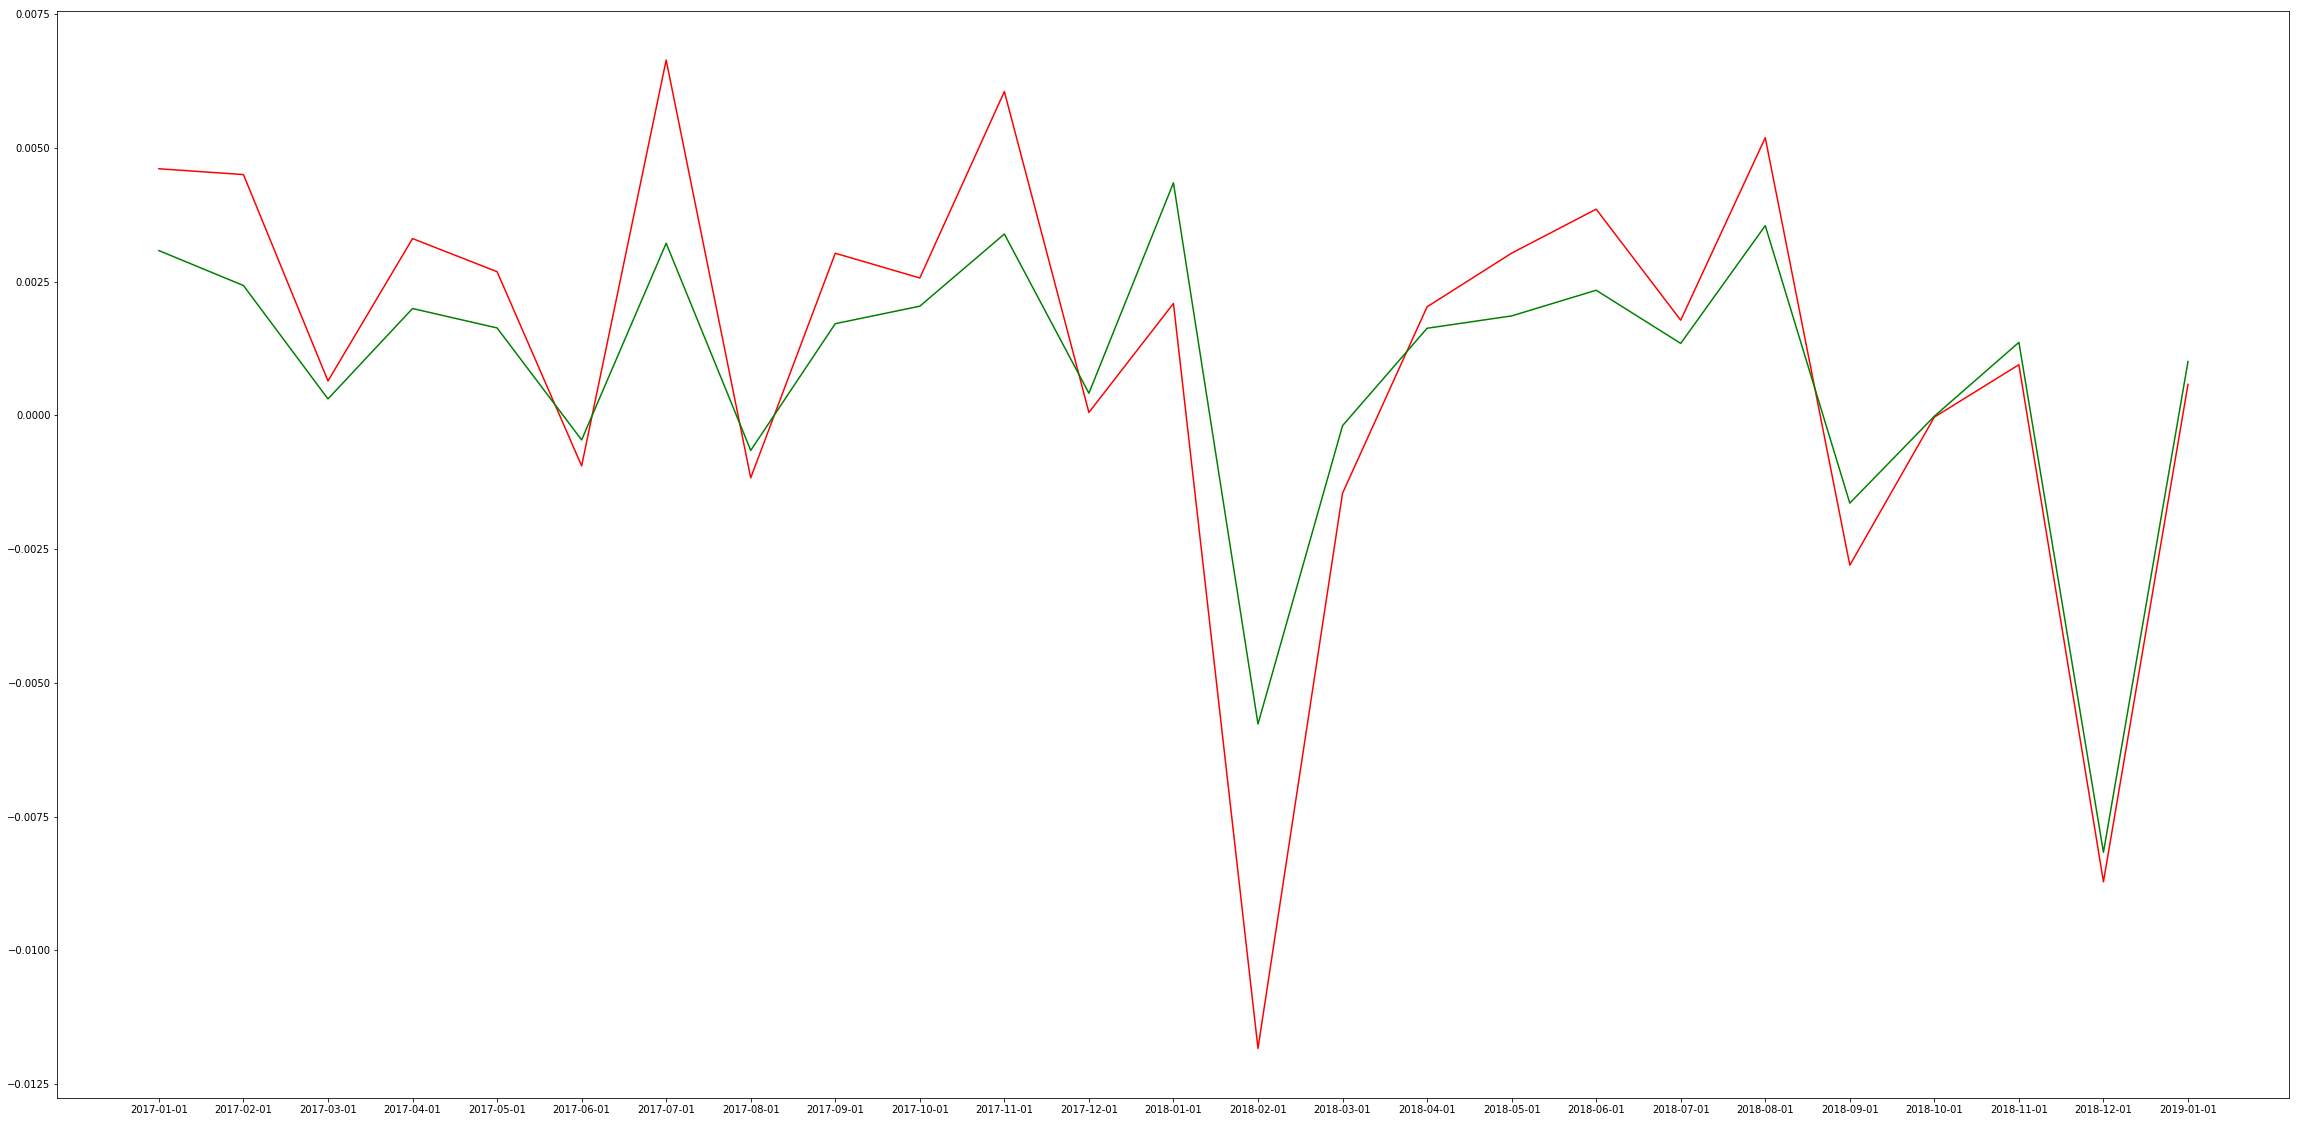

In [241]:
plt.figure(figsize=(40,20))
plt.plot(test,'r')
plt.plot(test01,'g')

In [243]:
print(test.mean(),test01.mean())

0    0.001064
dtype: float64 0    0.000829
dtype: float64
